In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque
from toolz.curried import *

In [33]:
df = pd.read_csv('data/1/human/N2/graph.csv')
pdf = pd.read_csv('data/1/human/N2/participants.csv')
pdf = pdf.rename(columns={'PR_type': 'pr_type'})
pdf.pr_type = pdf.pr_type.apply(get(seq=['none', 'full', 'approx']))

import ast
df.delays = df.delays.apply(ast.literal_eval).apply(tuple)
df.clicks = df.clicks.apply(ast.literal_eval).apply(tuple)

df['pr_typex'] = (df.condition % 3).astype(int)
df['pr_type'] = df.pr_typex.apply(get(seq=['none', 'full', 'approx']))
df['info_cost'] = (df.condition // 3).astype(int).apply(get(seq=[0.01, 1.6, 2.8]))
# df['pr_type'] = list(pdf.pr_type.iloc[df.pid].apply(get(seq=['0_none', '1_full', '2_approx'])))
df['info_cost'] = list(pdf.info_cost.iloc[df.pid])
pdf['condition'] = pdf.pr_type + '_' + pdf.info_cost.astype(str)
df['n_clicks'] = df.clicks.apply(len)
df['reward'] = df.score + (df.info_cost * df.n_clicks)
pdf['n_clicks'] = df.groupby('pid').n_clicks.mean()
pdf['score'] = df.groupby('pid').score.mean()
pdf['reward'] = df.groupby('pid').reward.mean()

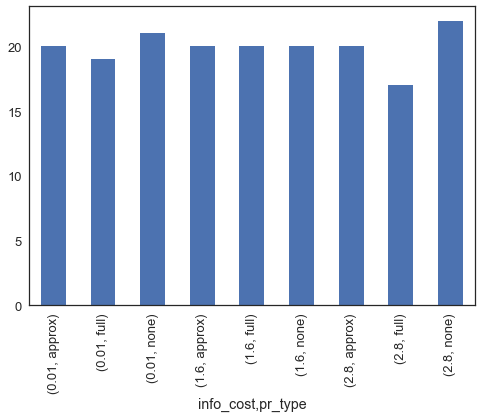

In [34]:
pdf.groupby(['info_cost', 'pr_type']).apply(len).plot.bar()

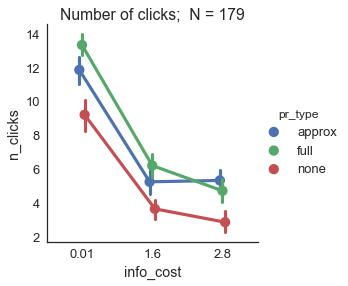

In [35]:
sns.factorplot('info_cost', 'n_clicks', hue='pr_type', data=df, dodge=True)
plt.title('Number of clicks;  N = {}'.format(len(pdf)))

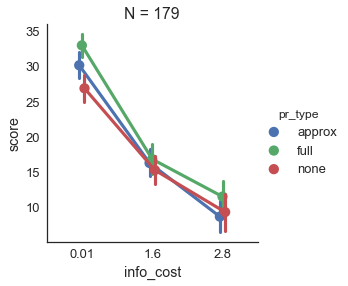

In [36]:
sns.factorplot('info_cost', 'score', hue='pr_type', data=df, dodge=True)
plt.title('N = {}'.format(len(pdf)))

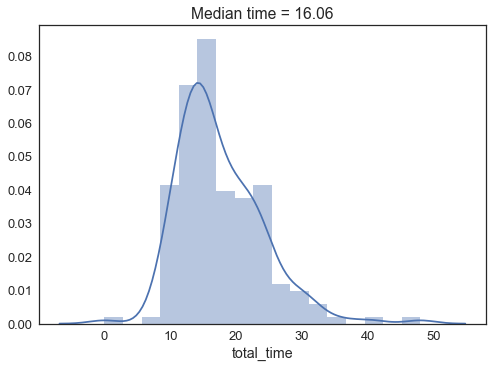

In [37]:
pdf['total_time'] = df.groupby('pid').time_elapsed.max().clip(0) / 60000
sns.distplot(pdf.total_time)
plt.title('Median time = {:.2f}'.format(pdf.total_time.median()))

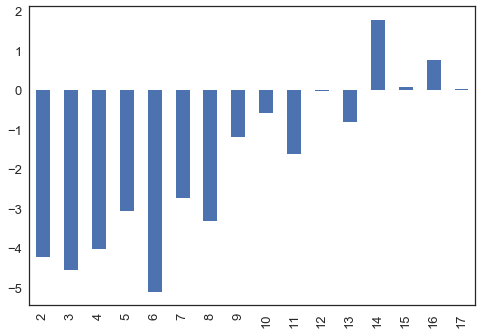

In [211]:
states = list(map(int, (unique(concat(df.clicks)))))
cdf = pd.DataFrame({s: df.query('info_cost == 1.60').clicks.apply(lambda x: str(s) in x) 
                    for s in states})
cdf['score'] = df.score

ss = pd.Series({s: cdf.score[cdf[s]].mean() - cdf.score[~cdf[s]].mean() for s in states})
ss.plot.bar()
# cdf.mean().drop('score').plot.bar()

(0, 40)

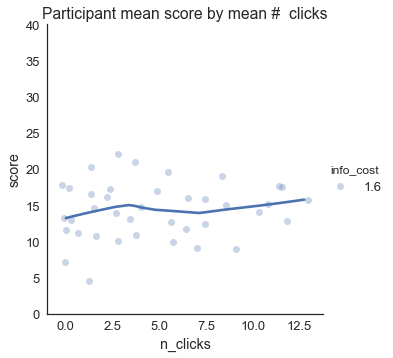

In [30]:
sns.lmplot('n_clicks', 'score', hue='info_cost',
           scatter_kws=dict(alpha=0.3),
           data=pdf,
           x_jitter=.2,
           lowess=True)
plt.title('Participant mean score by mean #  clicks')
plt.ylim(0, 40)

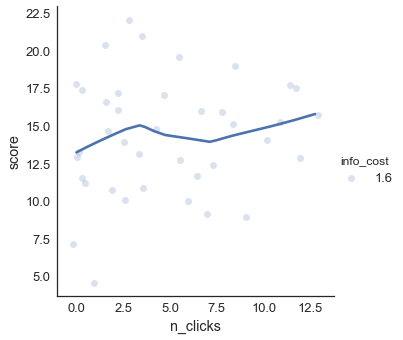

In [29]:
sns.lmplot('n_clicks', 'score', hue='info_cost',
           scatter_kws=dict(alpha=0.2),
           data=pdf,
           x_jitter=.2,
           lowess=True)

/usr/local/lib/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


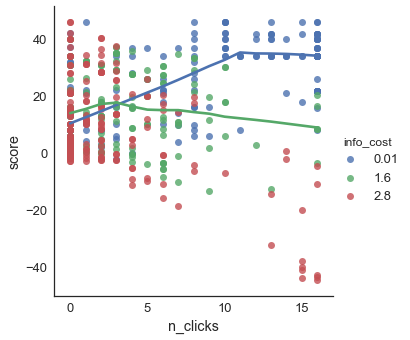

In [32]:
sns.lmplot('n_clicks', 'score', hue='info_cost', data=tdf, lowess=True)

In [95]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [96]:
rcols = ['score', 'info_cost', 'pr_type', 'pid', 'trialID']
rdf = df[rcols].copy()

In [97]:
# score_a = df.query('pr_type == "approx"').score
# score_f = df.query('pr_type == "full"').score

# # n_sample = min(map(len, (score_a, score_f)))
# n_sample = 100000
# (score_a.sample(n_sample, replace=True).as_matrix()
#  > score_f.sample(n_sample, replace=True).as_matrix()).mean()

ValueError: a must be greater than 0

In [ ]:
from pymc3 import *

with Model():
    glm.GLM.from_formula('score ~ pr_type', data=df.query('info_cost == 1.6'))
    trace = sample(3000)

    

In [ ]:
t = trace[1000:]
# t['pr_type[T.full]']
t[0]
(t['pr_type[T.2_approx]'] > t['pr_type[T.1_full]']).mean()

In [118]:
df.groupby('pid').time_elapsed.max() / 60000

pid
0      19.682850
1      15.262883
2      15.010100
3       9.555083
4      20.299917
5      14.287733
6      10.742600
7      30.439350
8      13.424967
9      16.076917
10     16.309450
11     15.249267
12      7.974317
13     15.275233
14     14.519233
15     16.247733
16     13.331650
17     14.881800
18     10.988700
19     22.415817
20     19.455800
21     16.911267
22     20.812667
23     10.943133
24     13.516233
25     19.677000
26      8.868517
27     20.247550
28     16.056350
29     19.135467
         ...    
99     12.631417
100    10.386917
101    40.438333
102    27.537550
103    25.315317
104    14.778667
105    24.899383
106    13.207333
107    13.908900
108    12.077250
109    17.358133
110    12.378683
111    12.052350
112    12.570933
113    12.510767
114    11.496583
115    13.818100
116     9.998517
117    17.486217
118    11.552917
119    13.274600
120    14.464783
121     8.890333
122    29.912133
123    13.897883
124    13.086083
125     9.495567
126    31.

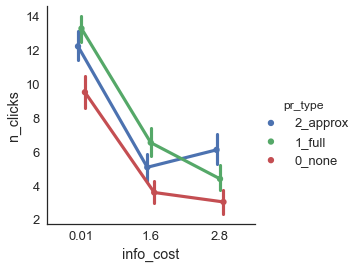

In [112]:
sns.factorplot('info_cost', 'n_clicks', hue='pr_type', data=df, dodge=.1, markers='.')
# plt.title('Score without click penalties')

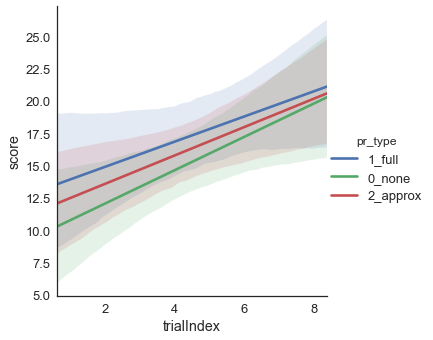

In [100]:
sns.lmplot('trialIndex', 'score', hue='pr_type', data=df.query('info_cost == 1.6'),
           x_jitter=.2,
           scatter=False,
#            lowess=True,
           
#            dodge=True
          )

In [101]:
%%R -i rdf
rdf$pr_type = relevel(rdf$pr_type, 'none')
m = lm(score ~ pr_type,  data=subset(rdf, info_cost = 1.6))

library(coin)
pm = oneway_test(score~pr_type, data=rdf,
  distribution=approximate(B=9999))
pm
# summary(m)


Error in relevel.factor(rdf$pr_type, "none") : 
  'ref' must be an existing level


/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in relevel.factor(rdf$pr_type, "none") : 
  'ref' must be an existing level

  warnings.warn(x, RRuntimeWarning)


In [102]:
%%R -i rdf
require(lme4)
require(car)
require(lsmeans)
# df <- within(df, pr_type <- relevel(pr_type, ref = 'none'))
rdf$pr_type = relevel(rdf$pr_type, 'none')
m = lmer(score ~ pr_type + (1|pid) + (1|trialID),  data=subset(rdf, info_cost = 1.6))
summary(m)
# Anova(m)


/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)



Error in relevel.factor(rdf$pr_type, "none") : 
  'ref' must be an existing level


/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: car

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lsmeans

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: estimability

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: package ‘car’ was built under R version 3.3.2 

  warn